In [37]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [38]:
device = 'cuda'
batch_size = 128
noise_dim = 64 #shape of the random noise vector

#optimizer parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#Training variables
epochs = 50


# Load MNIST Dataset

In [39]:
from torchvision import datasets, transforms as T

In [40]:
train_augs = T.Compose([
                        T.RandomRotation((-20,+20)),
                        T.ToTensor()
                        ])
trainset = datasets.MNIST('MNIST/', download = True, transform = train_augs)

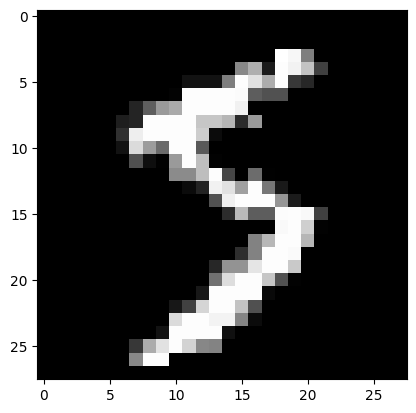

In [41]:
image, label = trainset[0]

plt.imshow(image.squeeze(), cmap = 'gray')

In [42]:
print('total images in the trainset are : ',len(trainset))

total images in the trainset are :  60000


# Load Dataset Into Batches

In [43]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [44]:
trainloader = DataLoader(trainset,batch_size = batch_size, shuffle = True)

In [45]:
print('total num of batches in trainloader : ',len(trainloader))

total num of batches in trainloader :  469


In [46]:
dataiter = iter(trainloader)
images, _ = next(dataiter)

print(image.shape)

torch.Size([1, 28, 28])


In [47]:
# 'show_tensor_images' : uses to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

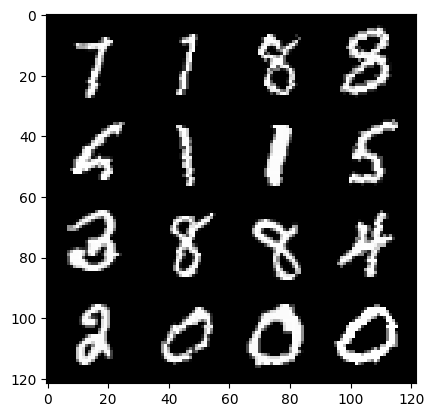

In [48]:
show_tensor_images(images)

# Create Discriminator Network

In [49]:
from torch import nn
from torchsummary import summary

In [50]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [51]:
def get_disc_block(in_channels,out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )


In [52]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [53]:
D = Discriminator()
D.to(device)
summary(D, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [54]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [55]:
def get_gen_block(in_channels,out_channels, kernel_size, stride, final_block=False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
  )


In [56]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)
    self.block_4 = get_gen_block(64,1,(4,4),2,final_block = True)

  def forward(self,r_noise_vec):
    x = r_noise_vec.view(-1,self.noise_dim,1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [57]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [58]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [59]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [63]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [64]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6854657753189998 | G_loss : 0.6905708075332235


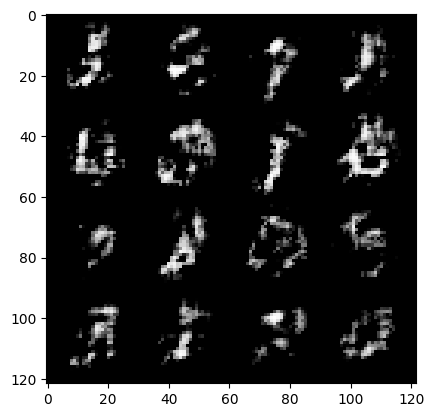

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6785200141640361 | G_loss : 0.7118938061982584


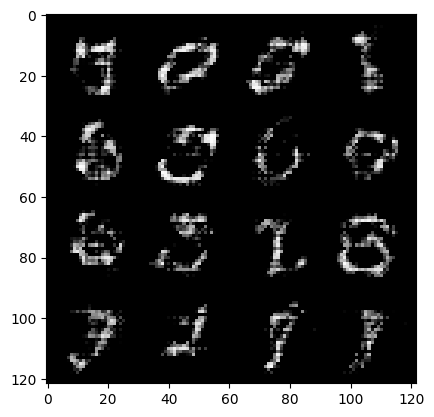

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6447668092083066 | G_loss : 0.7511260266751368


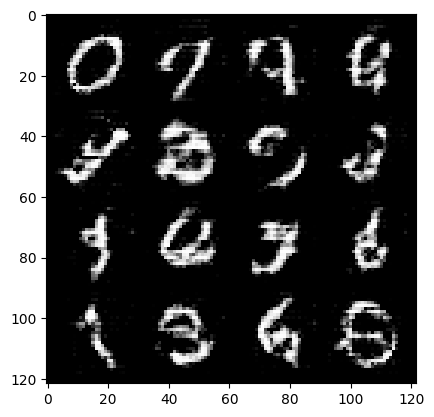

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6275117629880844 | G_loss : 0.7755272459627977


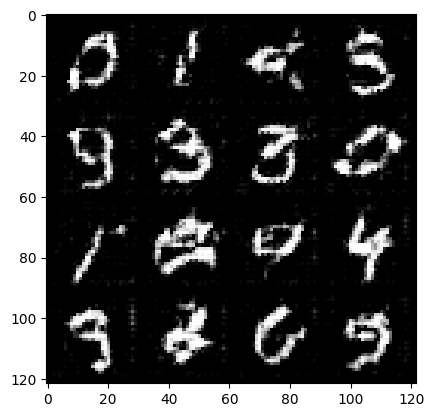

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.6208834659570316 | G_loss : 0.7922596728115447


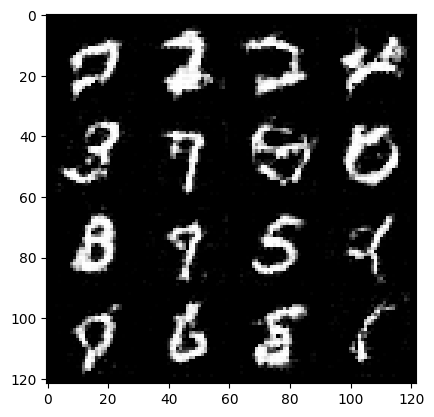

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.6101460539455861 | G_loss : 0.8154282736371575


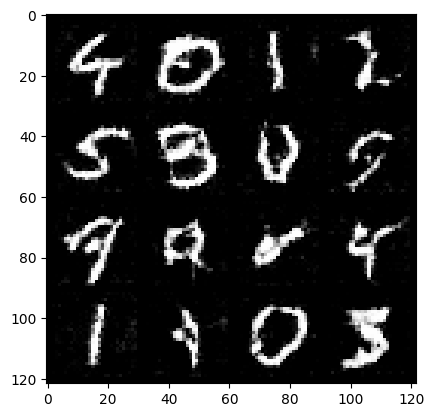

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6117610939021813 | G_loss : 0.8254023196854825


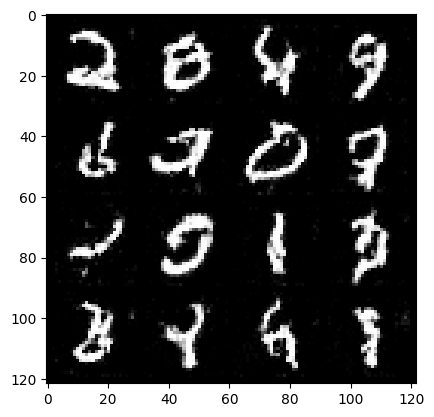

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6198791443411984 | G_loss : 0.823956365905591


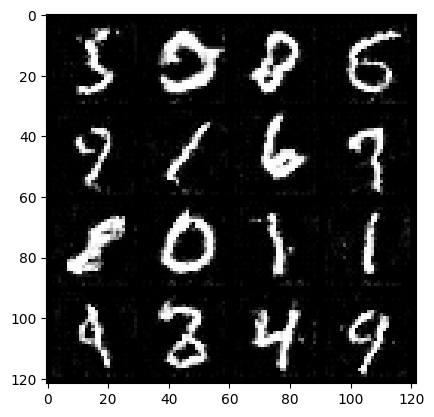

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6240402695212537 | G_loss : 0.8228764478077513


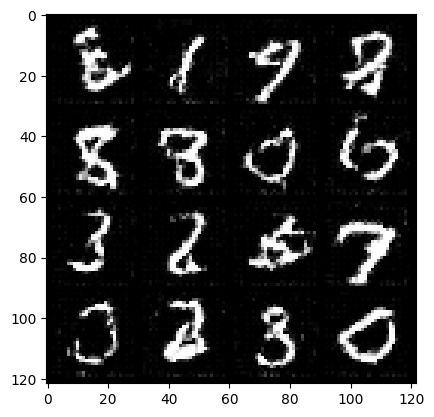

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.629533928340432 | G_loss : 0.8188369424104183


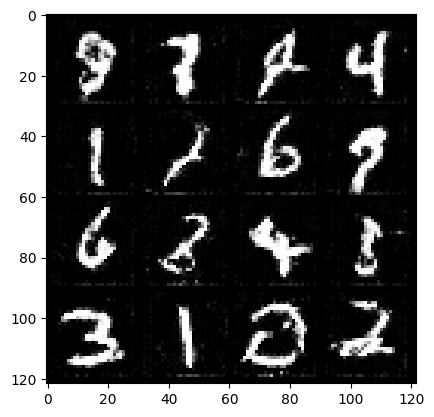

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6334418017726972 | G_loss : 0.8165201157140833


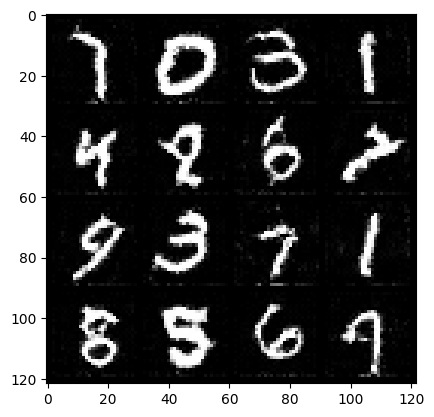

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.636579919090149 | G_loss : 0.8121305541443163


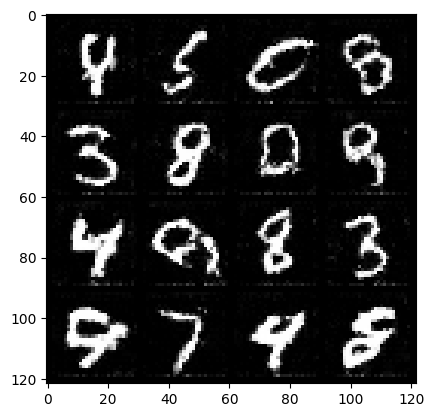

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6401566036982831 | G_loss : 0.8091791350958444


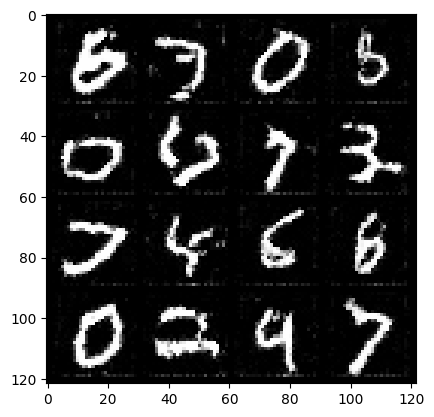

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6423328041013624 | G_loss : 0.8082711896154163


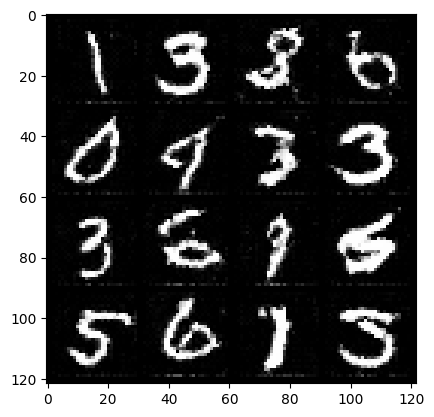

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.642195906084992 | G_loss : 0.8096102191441095


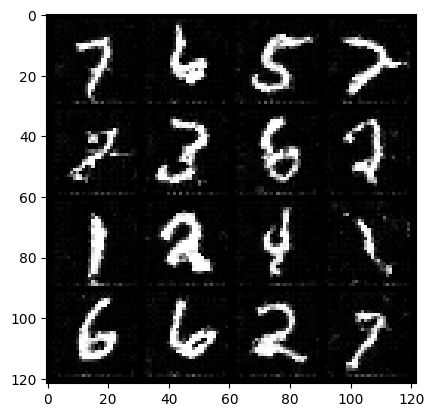

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6437322427469022 | G_loss : 0.8076072650423436


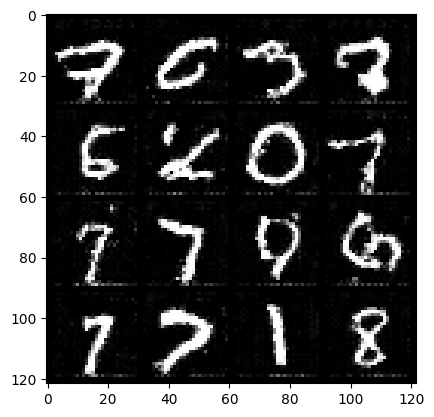

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6451564362562542 | G_loss : 0.8066758598600116


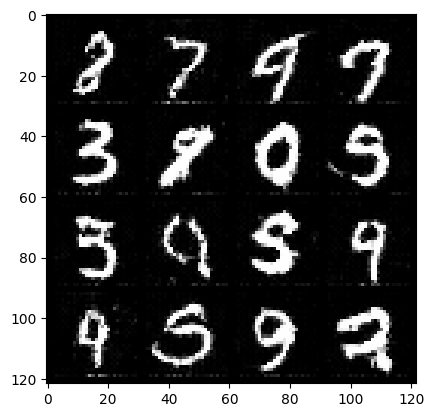

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6454131875210988 | G_loss : 0.8059206061017539


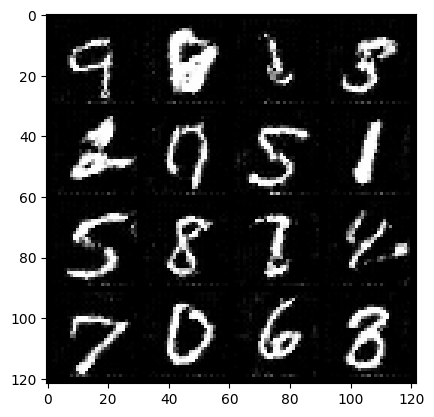

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6478655509857226 | G_loss : 0.8042267588918397


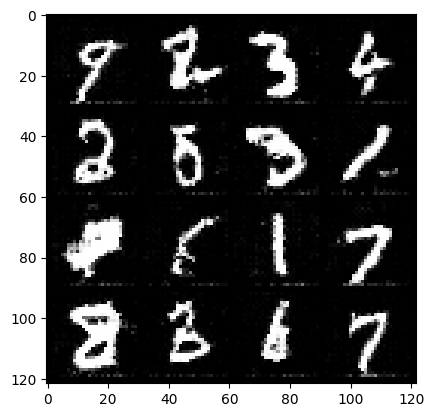

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6472338307132599 | G_loss : 0.8048147010142361


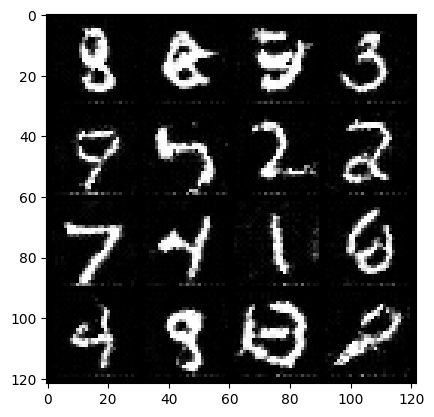

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 21 | D_loss : 0.6482265403529982 | G_loss : 0.8028039238346156


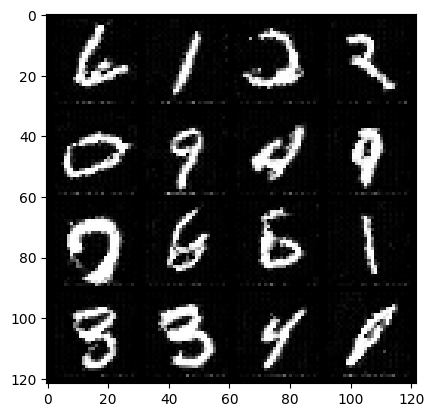

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 22 | D_loss : 0.6480710569983607 | G_loss : 0.8051256208277461


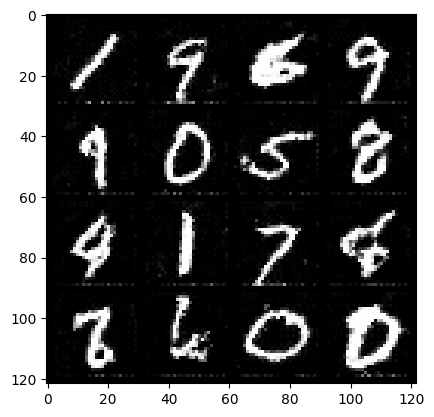

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 23 | D_loss : 0.6473140063316329 | G_loss : 0.8074952995599206


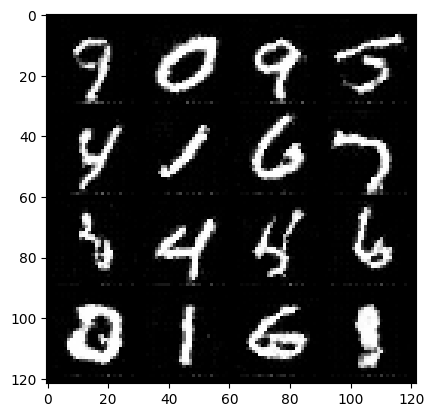

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 24 | D_loss : 0.6463847606421025 | G_loss : 0.8074971765343314


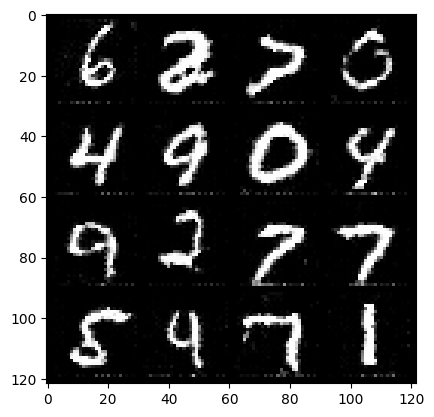

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 25 | D_loss : 0.6451512533210234 | G_loss : 0.812938947794534


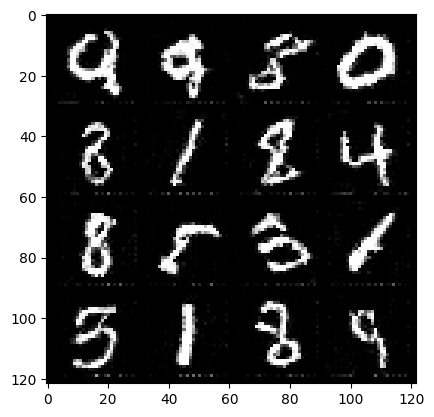

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 26 | D_loss : 0.6453611543183642 | G_loss : 0.8128882753315256


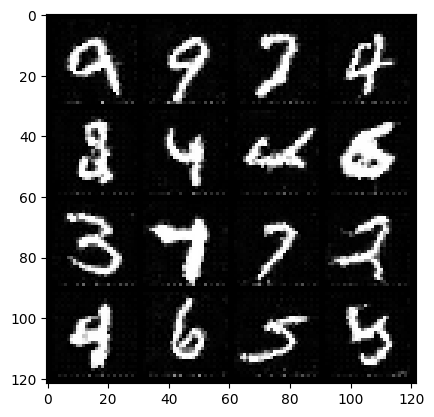

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 27 | D_loss : 0.6440290328282029 | G_loss : 0.8144324393923095


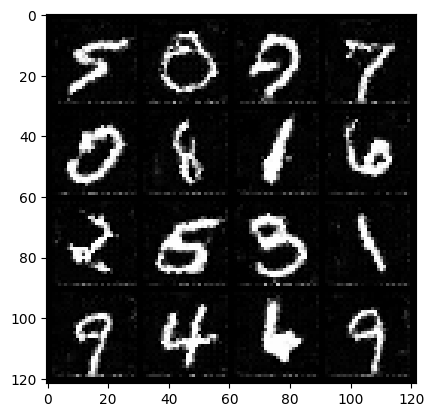

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 28 | D_loss : 0.6434684752909614 | G_loss : 0.8172485955488453


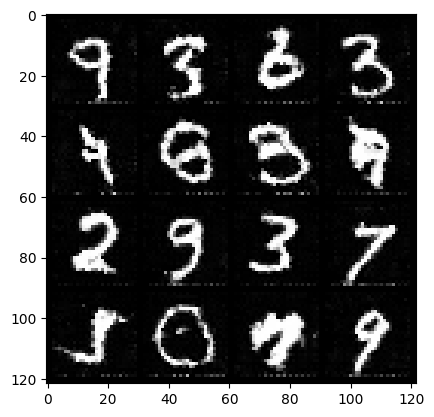

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 29 | D_loss : 0.6428092002614475 | G_loss : 0.8208523457492592


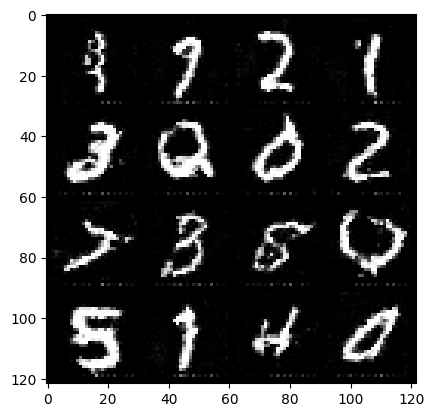

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 30 | D_loss : 0.6415642456713516 | G_loss : 0.8263108776068129


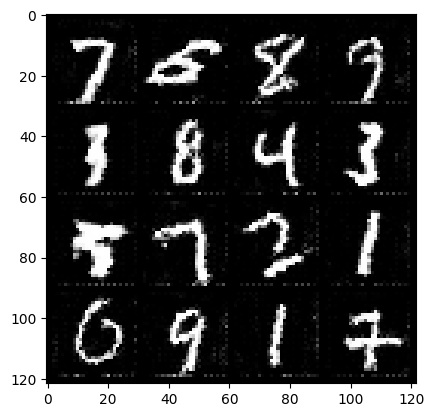

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 31 | D_loss : 0.6393039887393716 | G_loss : 0.8258712207838925


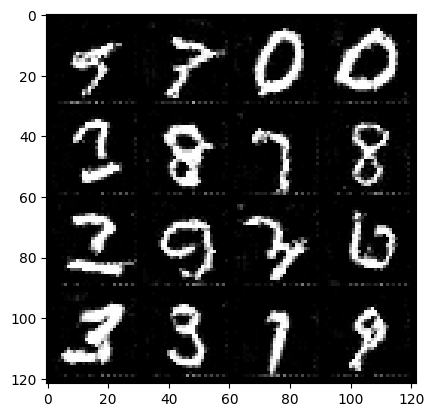

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 32 | D_loss : 0.6362123147511025 | G_loss : 0.8322036699699694


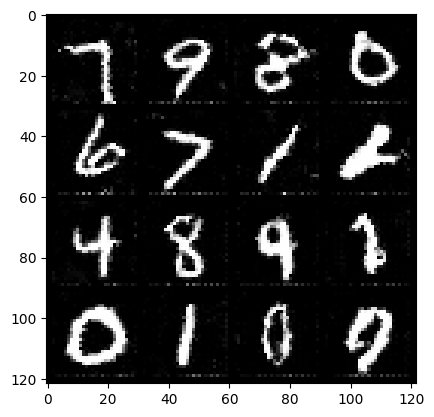

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 33 | D_loss : 0.6345052185343273 | G_loss : 0.8384970303283317


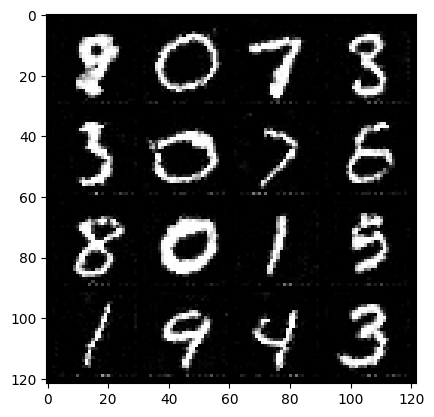

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 34 | D_loss : 0.6328607708660524 | G_loss : 0.8437513874283732


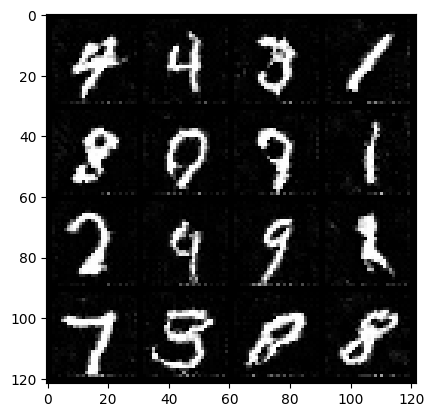

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 35 | D_loss : 0.6318321361470578 | G_loss : 0.8458483658873959


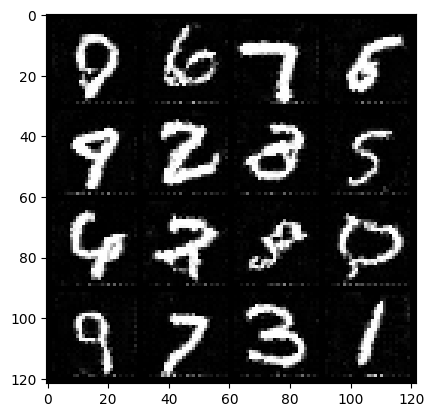

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 36 | D_loss : 0.6298272900744033 | G_loss : 0.8487494117669714


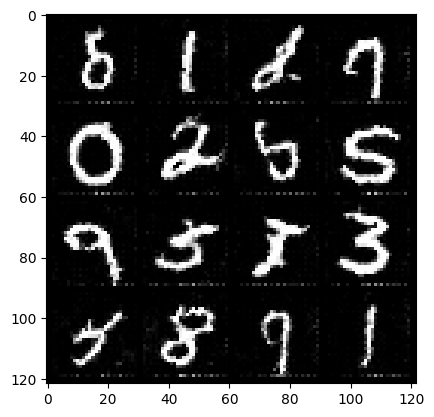

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 37 | D_loss : 0.6292613308821151 | G_loss : 0.8581181042738306


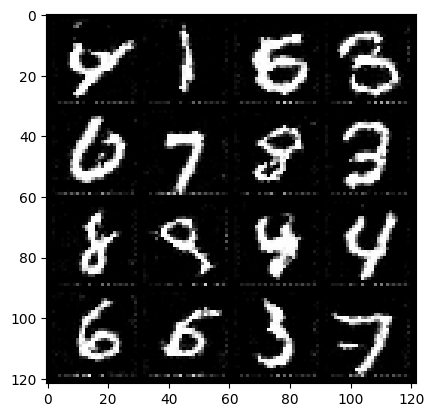

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 38 | D_loss : 0.6282194076316443 | G_loss : 0.8569937657191555


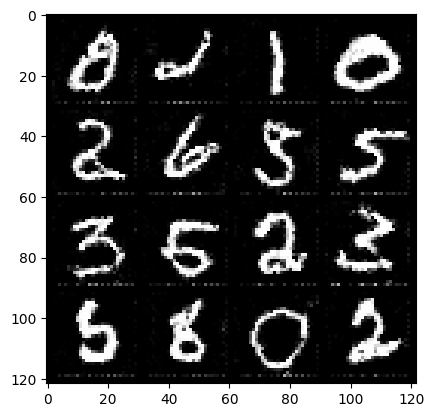

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 39 | D_loss : 0.6280888021627723 | G_loss : 0.860659315133654


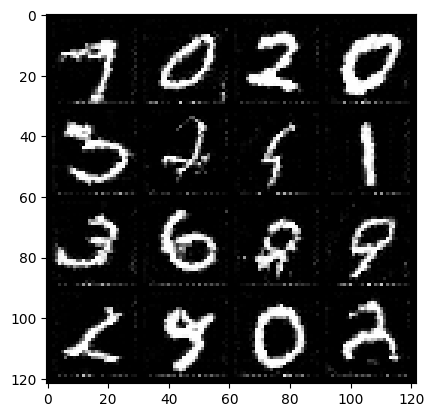

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 40 | D_loss : 0.6262753338956121 | G_loss : 0.8629572381342906


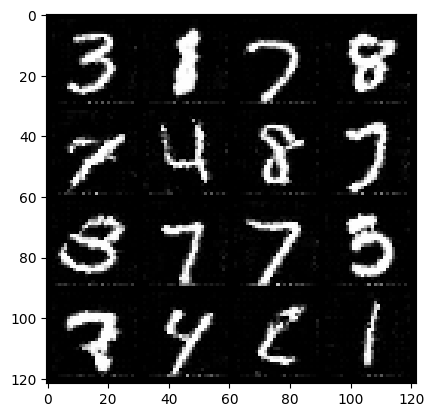

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 41 | D_loss : 0.6269745547125842 | G_loss : 0.8666016237059636


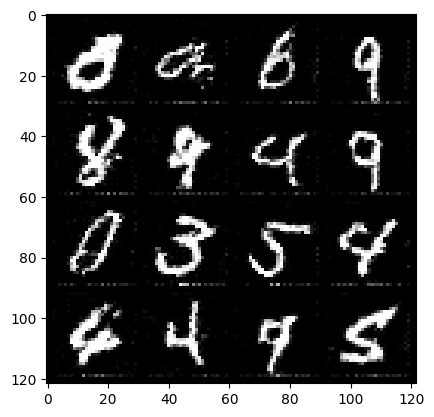

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 42 | D_loss : 0.6265455800841357 | G_loss : 0.8645490273229604


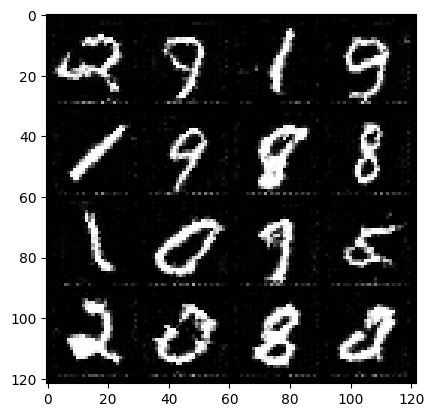

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 43 | D_loss : 0.6261740736107329 | G_loss : 0.8671084463215077


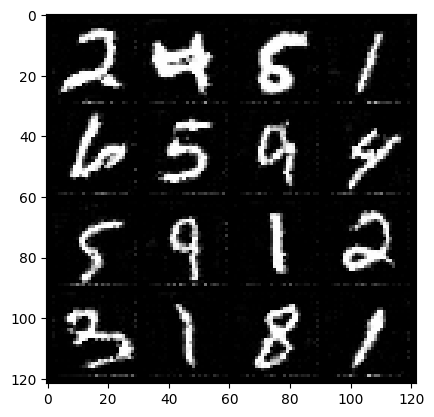

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 44 | D_loss : 0.6264324194586861 | G_loss : 0.8711385677364081


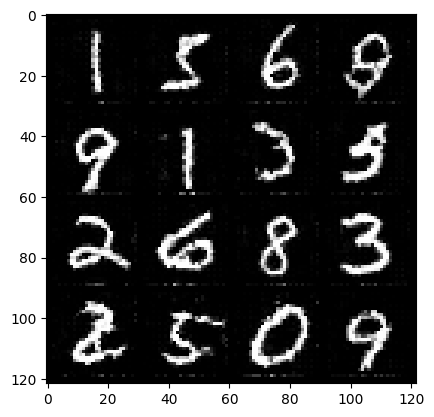

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 45 | D_loss : 0.6260304079889488 | G_loss : 0.8660974733865083


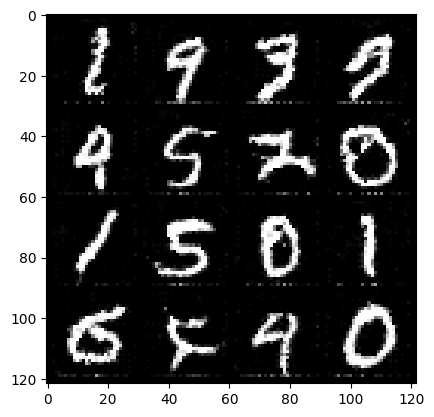

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 46 | D_loss : 0.6273825088543679 | G_loss : 0.8705527097431581


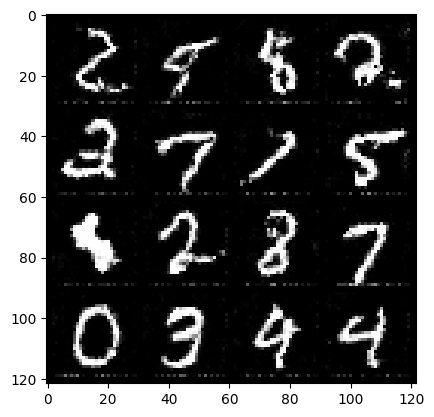

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 47 | D_loss : 0.6252429708997324 | G_loss : 0.8754544836371693


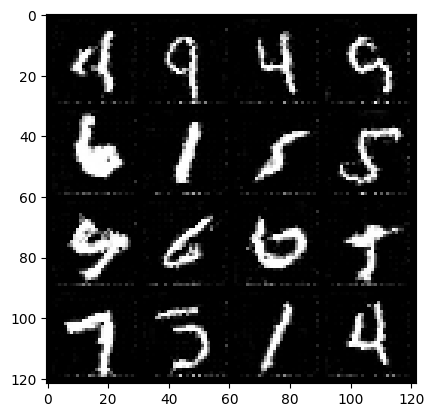

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 48 | D_loss : 0.6250578626386647 | G_loss : 0.8798501072153608


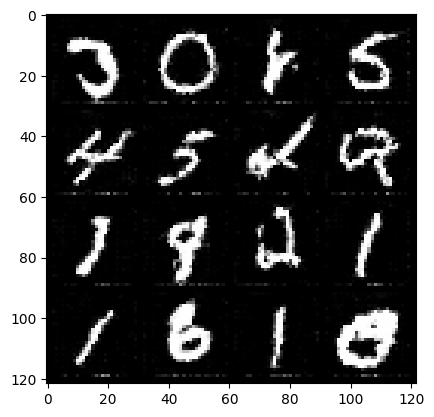

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 49 | D_loss : 0.6249109783660628 | G_loss : 0.8761427730385428


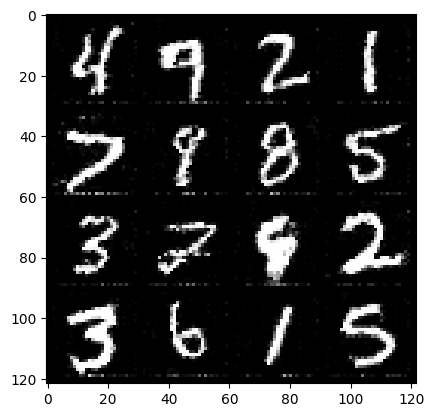

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 50 | D_loss : 0.6278091015846237 | G_loss : 0.8740425946107552


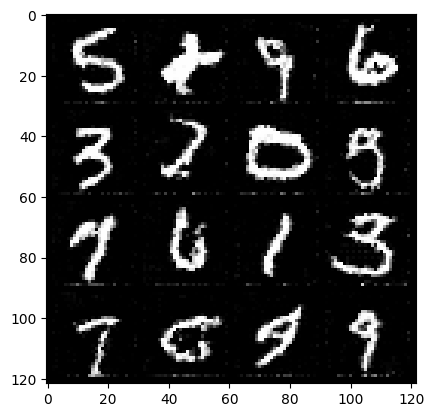

In [65]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss +=D_loss.item()

    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss +=G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print('Epoch : {} | D_loss : {} | G_loss : {}'.format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

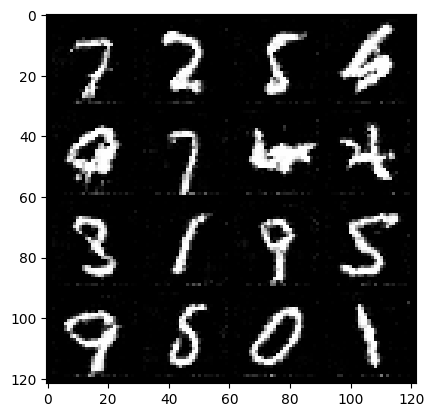

In [66]:
# Run after training is completed
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)